In [0]:
# imports for the tutorial
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [3]:
# define pre-processing steps on the images
# also called "data augementation" (only done for the train set)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# load dataset


trainset = torchvision.datasets.SVHN(
    root='./datasets', split='train', download=True, transform=transform_train)

testset = torchvision.datasets.SVHN(
    root='./datasets', split='test', download=True, transform=transform_test)

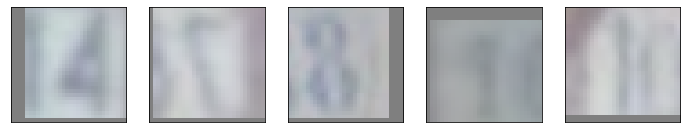

In [5]:
# let's see some of the images
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range - approximately...
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=5,
                                          shuffle=True)
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    #axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [0]:
class svhnNet(nn.Module):

    def __init__(self):
        """CNN Builder."""
        super(svhnNet, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [0]:
# time to train our model
# hyper-parameters
batch_size = 128
learning_rate = 1e-4
epochs = 20

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# build our model and send it to the device
model = svhnNet().to(device) # no need for parameters as we alredy defined them in the class

# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [12]:
# training loop
for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)
    
    # save model
    if epoch % 20 == 0:
        print('==> Saving model ...')
        state = {
            'net': model.state_dict(),
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, './checkpoints/cifar_cnn_ckpt.pth')

print('==> Finished Training ...')

Epoch: 1 | Loss: 1.3084 | Training accuracy: 78.993% | Test accuracy: 79.287% | Epoch Time: 44.06 secs
Epoch: 2 | Loss: 0.5432 | Training accuracy: 85.479% | Test accuracy: 84.949% | Epoch Time: 43.23 secs
Epoch: 3 | Loss: 0.4080 | Training accuracy: 89.342% | Test accuracy: 89.206% | Epoch Time: 43.87 secs
Epoch: 4 | Loss: 0.3505 | Training accuracy: 90.333% | Test accuracy: 90.339% | Epoch Time: 43.39 secs
Epoch: 5 | Loss: 0.3183 | Training accuracy: 91.745% | Test accuracy: 91.618% | Epoch Time: 43.03 secs
Epoch: 6 | Loss: 0.2922 | Training accuracy: 92.064% | Test accuracy: 92.548% | Epoch Time: 43.50 secs
Epoch: 7 | Loss: 0.2736 | Training accuracy: 92.118% | Test accuracy: 92.371% | Epoch Time: 43.15 secs
Epoch: 8 | Loss: 0.2580 | Training accuracy: 92.981% | Test accuracy: 92.978% | Epoch Time: 43.12 secs
Epoch: 9 | Loss: 0.2425 | Training accuracy: 93.427% | Test accuracy: 93.181% | Epoch Time: 43.96 secs
Epoch: 10 | Loss: 0.2343 | Training accuracy: 94.054% | Test accuracy: 93

test accuracy: 94.634%


NameError: ignored

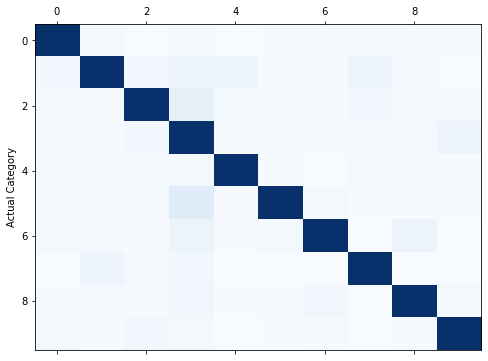

In [13]:
# load model, calculate accuracy and confusion matrix
model = svhnNet().to(device)
state = torch.load('./checkpoints/cifar_cnn_ckpt.pth', map_location=device)
model.load_state_dict(state['net'])

test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
#plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Dropout2d(p=0.05, inplace=False)
  (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU(inplace=True)
  (16): Conv2d(2

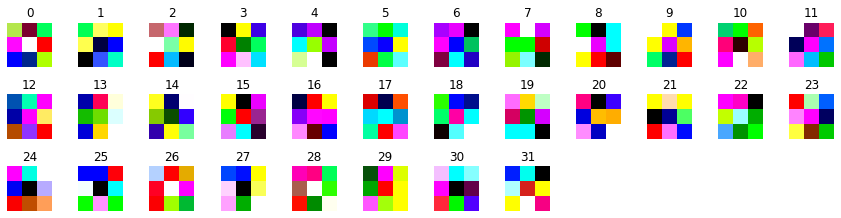

In [15]:
# visualize filters
# see available layers, in our case, the stacked layers are called "conv_layer"
print(model.conv_layer)
# extracting the model features at the particular layer number
layer = model.conv_layer[0]  # to plot other layers, see the appendix tutorial
# get the weights
weight_tensor = layer.weight.data.cpu()

# get the number of kernals
num_kernels = weight_tensor.shape[0]    

#define number of columns for subplots
num_cols = 12
# rows = num of kernels
num_rows = num_kernels

#set the figure size
fig = plt.figure(figsize=(num_cols, num_rows))

# looping through all the kernels
for i in range(weight_tensor.shape[0]):
    ax1 = fig.add_subplot(num_rows, num_cols, i+1)

    #for each kernel, we convert the tensor to numpy 
    npimg = np.array(weight_tensor[i].numpy(), np.float32)
    #standardize the numpy image
    npimg = (npimg - np.mean(npimg)) / np.std(npimg)
    npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
    npimg = npimg.transpose((1, 2, 0))
    ax1.imshow(npimg)
    ax1.axis('off')
    ax1.set_title(str(i))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

plt.tight_layout()